In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from product_fem import product_fem as pf
from product_fem.equations import DriftDiffusion
from fenics import *

## Drift-diffusion equation with sinusoidal analytic solution

Here we consider 

$$
\begin{align*}
    -\varepsilon\Delta u + \mathbf b \cdot \nabla u &= f \quad \mathrm{in}\, \Omega \\
    u(x,y) &= \sin(x)\sin(y)\quad \mathrm{on} \,\partial\Omega
\end{align*}
$$

when $\mathbf{b}(x,y) = (x, y)^T$ and 
$f(x,y) = 2\varepsilon\sin(x)\sin(y) + x \cos(x)\sin(y) + y \sin(x) \cos(y)$.
the analytic solution is $u(x,y) = \sin(x)\sin(y)$.
As long as $\mathbf b(x,y) = (b_1(x), b_2(y))^T$
the weak solution $u_h$ satisfies $Au_h = b$ where

$$
A_{ij,k\ell} = 
\varepsilon\int\! \phi_k'\hat\phi_i' \,dx
\int\! \phi_\ell\hat\phi_j \,dy 
+
\varepsilon\int\! \phi_k\hat\phi_i \,dx
\int\! \phi_\ell'\hat\phi_j' \,dy 
+
\int\! b_1\phi_k'\hat\phi_i \,dx
\int\! \phi_\ell\hat\phi_j \,dy
+
\int\! \phi_k\hat\phi_i \,dx
\int\! b_2\phi_\ell'\hat\phi_j \,dy
$$

and $b_{ij} = \sum_k\int\! X_k\hat\phi_i \,dx \int\! Y_k\hat\phi_j \,dy$
where $f(x,y) = \mathbf X(x) \cdot\mathbf Y(y)$.
In this case, 
$$\begin{align*}
    \mathbf X(x) &= (2\varepsilon\sin(x), x\cos(x), \sin(x))^T\\
\mathbf Y(y) &= (\sin(y), \sin(y), y\cos(y))^T
\end{align*}$$

To solve this in `product_fem` we need to create
ufl forms for each factor in $A = \sum_k^n B^{(k)}\otimes C^{(k)}$.
In this case $n=4$ and 

$$
\begin{align*}
    B_{ij}^{(1)} &= \int\! \varepsilon \phi_j'\hat\phi_i' \,dx \\
    C_{ij}^{(1)} &= \int\! \phi_j\hat\phi_i \,dy\\
    B_{ij}^{(2)} &= \int\! \phi_j\hat\phi_i \,dx \\
    C_{ij}^{(2)} &= \int\! \varepsilon \phi_j'\hat\phi_i' \,dy\\
    B_{ij}^{(3)} &= \int\! b_1\phi_j'\hat\phi_i \,dx \\
    C_{ij}^{(3)} &= \int\! \phi_j\hat\phi_i \,dy\\
    B_{ij}^{(4)} &= \int\! \phi_j\hat\phi_i \,dx \\
    C_{ij}^{(4)} &= \int\! b_2\phi_j'\hat\phi_i \,dy
\end{align*}
$$

In [9]:
def forward_solve(n, eps, error=False):
    # set up function space
    mesh = UnitIntervalMesh(n-1)
    h = mesh.hmax()
    V = FunctionSpace(mesh, 'CG', 1)
    W = pf.ProductFunctionSpace(V)

    # drift coefs
    b1 = Expression('x[0]', element=V.ufl_element())
    b2 = Expression('x[0]', element=V.ufl_element())
    b = (b1, b2)

    # force function f = sum_i X_iY_i
    X = ['2 * eps * sin(x[0])', 'x[0] * cos(x[0])', 'sin(x[0])']
    X = [Expression(x, element=V.ufl_element(), eps=eps) for x in X]
    Y = ['sin(x[0])', 'sin(x[0])', 'x[0] * cos(x[0])']
    Y = [Expression(y, element=V.ufl_element()) for y in Y]
    f = (X, Y)

    # boundary conditions
    u_bdy = lambda x, y: np.sin(x) * np.sin(y)
    bc = pf.ProductDirichletBC(W, u_bdy, 'on_boundary')

    # fem solution
    dd = DriftDiffusion(W, eps, b, f, bc)
    u_h = dd.solve()

    # analytic solution
    u = pf.Function(W)
    u.assign(u_bdy)
    u = u.array
    L2_error = np.sqrt(W.integrate((u - u_h)**2))
    
    if error:
        return h, L2_error
    else:
        return u_h

In [2]:
# def forward_solve(n, eps=1e-3, error=False):
#     mesh = UnitIntervalMesh(n-1)
#     h = mesh.hmax()
#     V = FunctionSpace(mesh, 'CG', 1)
#     W = pf.ProductFunctionSpace(V)
    
#     u, v = TrialFunction(V), TestFunction(V)
#     b_1 = Expression('x[0]', element=V.ufl_element())
#     b_2 = Expression('x[0]', element=V.ufl_element())
#     B_forms = [eps * u.dx(0) * v.dx(0) * dx,
#                u * v * dx,
#                b_1 * u.dx(0) * v * dx,
#                u * v * dx]
#     C_forms = [u * v * dx,
#                eps * u.dx(0) * v.dx(0) * dx,
#                u * v * dx,
#                b_2 * u.dx(0) * v * dx]
#     A_forms = list(zip(B_forms, C_forms))

#     # force function f = sum_i X_iY_i
#     X = ['2 * eps * sin(x[0])', 'x[0] * cos(x[0])', 'sin(x[0])']
#     X = [Expression(x, element=V.ufl_element(), eps=eps) for x in X]

#     Y = ['sin(x[0])', 'sin(x[0])', 'x[0] * cos(x[0])']
#     Y = [Expression(y, element=V.ufl_element()) for y in Y]
    
#     c_forms = [fx * v * dx for fx in X]
#     d_forms = [fy * v * dx for fy in Y]
#     b_forms = list(zip(c_forms, d_forms))
    
#     # boundary condition is analytic solution
#     u_bdy = lambda x, y: np.sin(x) * np.sin(y)
#     bc = pf.ProductDirichletBC(W, u_bdy, 'on_boundary')
    
#     A, b = pf.assemble_product_system(A_forms, b_forms, bc)
#     U = np.linalg.solve(A, b)
    
#     if error:
#         dPhi = assemble(v * dx)[:]
#         dPhi = np.kron(dPhi, dPhi) # mass measure for L2 norm

#         u_true = np.zeros_like(U)
#         dof_to_coords = W.dofmap._dofs_to_coords
#         for dof, xy in dof_to_coords.items():
#             u_true[dof] = u_bdy(*xy)
#         L2_error = np.sqrt(np.dot((U - u_true)**2, dPhi))
#         return h, L2_error
#     else:
#         return U

In [10]:
def mesh_convergence(eps=1):
    # organize data frame
    ns = [6, 11, 21]
    h_errors = np.array([forward_solve(n, eps=eps, error=True) for n in ns])
    hs, l2_err = h_errors[:,0], h_errors[:,1]
    data = {'n': ns, 'h': hs, 'log_h': np.log(hs), 'l2_err': l2_err, 'log_l2_err': np.log(l2_err)}
    data = pd.DataFrame(data)

    # perform regression and plot
    slope, intercept, r, p, se = stats.linregress(data['log_h'], data['log_l2_err'])
    line_kws={'label':fr'$\log(\parallel u - u_h\parallel_2) = {np.round(slope, 4)} \log(h) + {np.round(intercept, 1)}$'}
    ax = sns.regplot(x='log_h', y='log_l2_err', data=data, 
                     ci=None, order=1, line_kws=line_kws)
    # aesthetics
    ax.figure.set_dpi(100)
    ax.figure.set_figheight(6)
    ax.figure.set_figwidth(6)
    ax.set_xlabel(r'$\log(h)$')
    ax.set_ylabel(r"$ log(\parallel u - u_h\parallel_2)$")
    ax.set_title(fr'$r^2 = {r**2}$')
    ax.legend()
    plt.show()

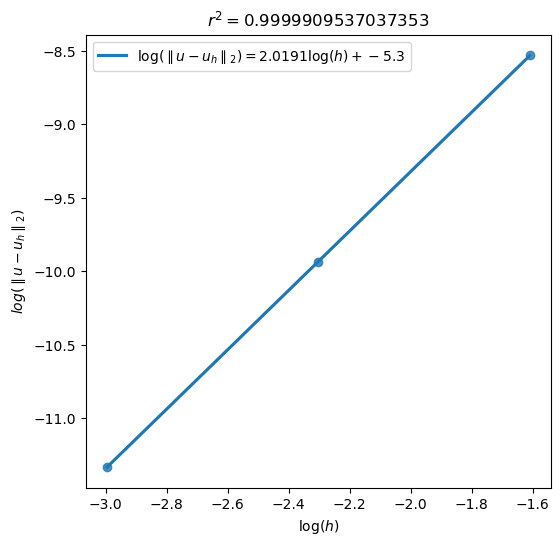

In [11]:
mesh_convergence(1)

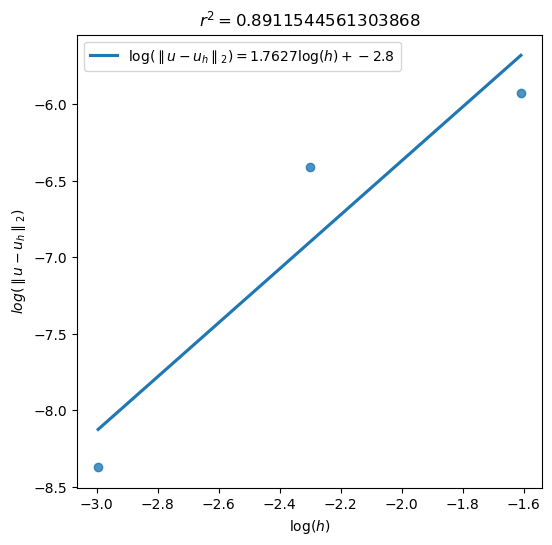

In [12]:
mesh_convergence(1e-3)

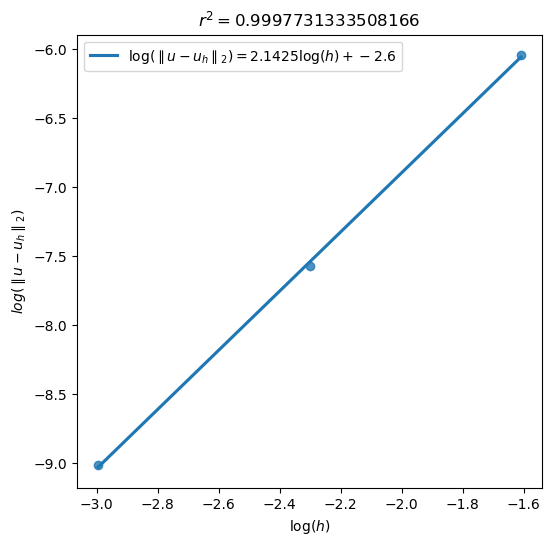

In [13]:
mesh_convergence(1e-6)